# **Required imports**


In [0]:
import sys
SRC_PATH = '/content/gdrive/My Drive/Colab Notebooks/TetrisEngine' # CHANGE ACCORDINGLY
#SRC_PATH = '/content/gdrive/My Drive/Colab Notebooks/DL2020/Final project'
sys.path.append(SRC_PATH)

import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import time
import cv2
from time import sleep

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D
from collections import deque
import pickle

import itertools as it

# Mount Drive

In [14]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


# **Importing the Tetris env**


In [0]:
from engine import TetrisEngine

# **Setting some parameters**
This way we get rid of these "magic numbers"

In [0]:
ROTATE_LEFT_ACTION = 0
ROTATE_RIGHT_ACTION = 1
RIGHT_ACTION = 2
LEFT_ACTION = 3
SOFT_DROP_ACTION = 4
HARD_DROP_ACTION = 5

AGENT_OBSERVATION_SPACE = (20,10,1)
AGENT_ACTION_SPACE = [ROTATE_LEFT_ACTION,ROTATE_RIGHT_ACTION,RIGHT_ACTION,LEFT_ACTION,SOFT_DROP_ACTION, HARD_DROP_ACTION]

# **Defining the agent (includes the training)**

In [0]:
class Agent():
  def __init__(self, epsilon, epsilon_min, epsilon_decay):
    self.action_size = len(AGENT_ACTION_SPACE)
    self.observation_shape = AGENT_OBSERVATION_SPACE[0]*AGENT_OBSERVATION_SPACE[1]*AGENT_OBSERVATION_SPACE[2]

    self.memory  = deque()
    #self.reward_history = []
    
    self.gamma = 0.8

    self.epsilon = epsilon
    self.epsilon_min = epsilon_min
    self.epsilon_decay = epsilon_decay

    self.learning_rate = 0.001
    self.tau = .05
    self.errors = []
    self.epochs = 1
    self.steps_since_target_update = 0
    self.steps_between_target_updates = 100
    self.replay_batch_size = 32
    #self.avg_window_size = 32

    # does the actual predictions on what action to take
    self.model = self.create_model()

    # tracks what action we want our model to take.
    # this network changes more slowly and tracks our eventual goal
    self.target_model = self.create_model()
  
  def new_episode(self):
    self.errors = []

  def log(self):
    loss = np.mean(self.errors)
    print("Epsilon="+str(self.epsilon)+
          ". Avg q-value prediction NRMSE="+str(loss))
    return self.epsilon, loss
        
  def get_action(self, observation):
    self.epsilon *= self.epsilon_decay
    self.epsilon = max(self.epsilon_min, self.epsilon)
    
    if(len(self.memory) < self.replay_batch_size or np.random.random() < self.epsilon):
      return random.choice(range(self.action_size))

    return np.argmax(self.model.predict(observation)[0])

  def remember(self, observation, action, reward, new_observation, done):
    self.memory.append([observation, action, reward, new_observation, done])
    """
    self.reward_history.append(np.abs(reward))
    if(len(self.reward_history) > self.avg_window_size):
      self.reward_history = self.reward_history[:-self.avg_window_size]
    """

  def create_model(self):
    model = Sequential()
    model.add(Conv2D(32, (5, 5), padding='same',input_shape=(20, 10, 1)))
    model.add(Conv2D(48, (3,3), padding='same'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(48, (3,3), padding='same'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(256, activation="relu"))
    model.add(Dense(128, activation="relu"))
    model.add(Dense(128, activation="relu"))
    model.add(Dense(96, activation="relu"))
    model.add(Dense(self.action_size))

    model.compile(loss="mean_squared_error",
    optimizer=Adam(lr=self.learning_rate))

    return model

  def __save_model_weights(self, ep):
    model_weights_path = SRC_PATH+"/model_weights_"+str(ep)+".h5f"
    target_model_weights_path = SRC_PATH+"/target_model_weights_"+str(ep)+".h5f"
    try:
      self.model.save_weights(model_weights_path, overwrite=True)
      self.target_model.save_weights(target_model_weights_path, overwrite=True)
      print("Model weights saved succesfully")
    except:
      print("Saving model weights failed. Continuing...")

  def __save_replay_buffer(self, ep):
    buffer_path = SRC_PATH+"/replay_buffer_"+str(ep)+".pkl"
    try:
      pickle.dump(self.memory, open(buffer_path, 'wb'))
      print("Replay buffer saved succesfully")
    except:
      print("Saving replay buffer failed. Continuing...")

  def save_agent_state(self, ep):
    self.__save_model_weights(ep)
    self.__save_replay_buffer(ep)

  def replay(self):
    
    if len(self.memory) < self.replay_batch_size: 
         return

    batch = random.sample(self.memory, self.replay_batch_size)
    observations = np.array([x[0] for x in batch]).reshape(self.replay_batch_size, 20, 10, 1)
    new_observations = np.array([x[3] for x in batch]).reshape(self.replay_batch_size, 20, 10, 1)
    online_qs = self.model.predict(observations)
    target_qs = self.target_model.predict(new_observations)

    for i,sample in enumerate(batch):
         _, action, reward, _, done = sample
         if done:
             online_qs[i][action] = reward
         else:
             q_next = np.max(target_qs[i])
             online_qs[i][action] = reward + q_next * self.gamma
    e = self.model.fit(observations, online_qs, epochs=self.epochs, verbose=0)
    self.errors.append(np.sqrt(np.mean(e.history["loss"]))/np.abs(np.mean(online_qs)))

  def target_train(self):
    self.steps_since_target_update += 1
    if self.steps_since_target_update >= self.steps_between_target_updates:
      weights = self.model.get_weights()
      self.target_model.set_weights(weights)
      self.steps_since_target_update = 0

# **Filters the memories that are used for training**

In [0]:
class MemoryFilter():
  def __init__(self, agent):
    self.agent = agent
    self.last_consulted_memory_item = None
    self.last_unconsulted_memory_item = None
    self.did_last_step_consult_agent = True

  def remember(self, do_consult_agent, memory_item): 
    # (1)
    # If we were not consulting the agent in the last step, but now we are (A new piece has been placed on top)
    # -> Remember joined memories of last_consulted_memory_item and last_unconsulted_memory_item
    if not self.did_last_step_consult_agent and do_consult_agent:
      self.agent.remember(*joinMemories(self.last_consulted_memory_item, self.last_unconsulted_memory_item))            
      self.agent.replay()       # internally iterates default (prediction) model
      self.agent.target_train() # iterates target model

      self.last_consulted_memory_item = None
      self.last_unconsulted_memory_item = None

    # (2)
    # Do certain checks on item
    # eg. nparray filled with zeros will be discarded
    # eg. discard memory where no action is taken
    valid_memory_item = True

    # Stop if invalid
    if not valid_memory_item:
      return;

    # (3)
    if do_consult_agent:
      self.agent.remember(*memory_item)            
      self.agent.replay()       # internally iterates default (prediction) model
      self.agent.target_train() # iterates target model
      # save last memory-item in which the agent was consulted
      self.last_consulted_memory_item = memory_item

    else:
      self.last_unconsulted_memory_item = memory_item

  def joinMemories(memoryA, memoryB):
    return [memoryA[3], memoryB[1], memoryB[2], memoryB[3], memoryB[4]]


# **Reward function**

In [0]:
# REMARK: The new engine's state also includes 2's (for the current block) besides 0's and 1's

import engine
import copy

def custom_reward4(previous_state, current_state):
  HEIGHT_REWARD_FACTOR = 1
  WIDTH_REWARD_FACTOR = 1
  MAX_HEIGHT = 10
  stop = False

  previous_state = copy.deepcopy(previous_state)
  previous_state[previous_state == 2] = 0

  current_state = copy.deepcopy(current_state)
  current_state[current_state == 2] = 0

  pvs_h = engine.height(previous_state)
  c_h = engine.height(current_state)
  if(c_h>MAX_HEIGHT):
    stop = True

  pvs_w = max_width(previous_state)
  c_w = max_width(current_state)  

  height_reward = (pvs_h - c_h)*HEIGHT_REWARD_FACTOR
  width_reward = max(c_w - pvs_w,0)*WIDTH_REWARD_FACTOR

  return height_reward + width_reward, stop

def max_width(state):
    LINES_TO_EXPLORE = 4
    h = state.shape[0]
    w = state.shape[1]
    widths = []
    for i in range(LINES_TO_EXPLORE):
        widths.append(get_width(state[h-1-i]))
    return max(widths)

def get_width(a):
    cnt = 0
    res = 0
    n = len(a)
    for i in range(n):
        if(a[i]==0):
            cnt = 0
        else:
            cnt+=1
            res = max(res,cnt)
    return res

def custom_reward3(state, steps, done, new_block):
  MIN_STEPS_PER_EP = 1000
  stop=False
  h = engine.height(state)
  w = max_width(state)
  if(not(new_block)):
    return 0, stop
  else:
    if(w<=5):
      width_reward = -100*(10-w)
    else:
      width_reward = 100*w

    if(h>=10):
      steps_reward = steps - MIN_STEPS_PER_EP
      height_reward = -1000*(h-5)
      stop = True
    elif(h<=4):
      steps_reward = 0
      height_reward = 1000*(5-h)
    else:
      steps_reward = 0
      height_reward = 0
    
    return width_reward + height_reward + steps_reward, stop

def custom_reward2(state):
  try:
    l = info['number_of_lines']
  except:
    l = 0
  h = engine.height(state)
  r = custom_reward(state)
  if(h>=10):
    return r-10000 + l*1000
  elif(h<=4):
    return r+10000 + l*1000
  else:
    return r + l*1000

# reward parameters
a = -0.510066
b = 0.760666
c = -0.35663
d = -0.184483

def custom_reward(new_observation):
    new_observation = new_observation.reshape(20,10)

    # ignore current piece area
    for x in range(0, 5):
        new_observation = np.delete(new_observation, 0, 0)

    aggregate_height = compute_aggregate_height(new_observation)
    complete_lines = compute_complete_lines(new_observation)
    holes = compute_holes(new_observation)
    bumpiness = compute_bumpiness(new_observation)
    return a * aggregate_height + b * complete_lines + c * holes + d * bumpiness


# REMARK: Similar functions exist in engine.py
def compute_aggregate_height(observation):
    aggregate_height = 0
    for column in observation.T:
        aggregate_height += compute_column_height(column)
    return aggregate_height

def compute_complete_lines(observation):
    return  (observation.sum(axis=1) == 10).sum()


def compute_holes(observation):
    holes = 0
    for column in observation.T:
        prev_point = 0
        for point in column:
            if prev_point == 1 and point == 0:
                holes += 1
            prev_point = point 
    return holes

def compute_bumpiness(observation):
    bumpiness = 0
    prev_height = None
    for column in observation.T:
        column_height = compute_column_height(column)
        if prev_height != None:
            bumpiness += abs(column_height - prev_height)
        prev_height = column_height
    return bumpiness

# REMARK: Similar functions exist in engine.py
def compute_column_height(column):
    height = 0
    found_top = False
    for point in column:
        if not found_top:
            found_top = point == 1        
        if found_top:
            height += 1
    return height

# Some code for plots

In [0]:
import matplotlib.pyplot as plt

def make_plots(total_rewards, custom_reward, epsilons, losses, scores, lines, steps): 
  plt.plot(range(len(total_rewards)), total_rewards)
  plt.xlabel("Episode")
  plt.ylabel("Total Reward")
  plt.grid()
  plt.show()

  plt.plot(range(len(custom_reward)), custom_reward)
  plt.xlabel("Episode")
  plt.ylabel("Custom Reward")
  plt.grid()
  plt.show()

  plt.plot(range(len(epsilons)), epsilons)
  plt.xlabel("Episode")
  plt.ylabel("Epsilon")
  plt.grid()
  plt.ylim(0,1)
  plt.show()

  plt.plot(range(len(losses)), losses)
  plt.xlabel("Episode")
  plt.ylabel("Loss")
  plt.grid()
  plt.ylim(0,10)
  plt.show()

  plt.plot(range(len(scores)), scores)
  plt.xlabel("Episode")
  plt.ylabel("Game score")
  plt.grid()
  plt.show()

  plt.plot(range(len(lines)), lines)
  plt.xlabel("Episode")
  plt.ylabel("Number of cleared lines")
  plt.grid()
  plt.show()

  plt.plot(range(len(steps)), steps)
  plt.xlabel("Episode")
  plt.ylabel("Number of steps")
  plt.grid()
  plt.show()

# Trying some epsilon values

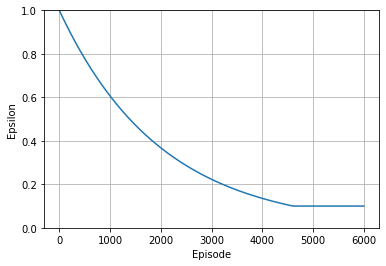

In [27]:
episodes = 6000
mean_steps = 100

epsilon = 0.99999
epsilon_min = 0.1
epsilon_decay = 0.999995

epsilon_projection = np.arange(episodes*mean_steps)
epsilon_projection = np.power(epsilon_decay, epsilon_projection)
epsilon_projection[epsilon_projection < epsilon_min] = epsilon_min
epsilon_projection = epsilon_projection[::mean_steps]

plt.plot(range(len(epsilon_projection)), epsilon_projection)
plt.xlabel("Episode")
plt.ylabel("Epsilon")
plt.grid()
plt.ylim(0,1)
plt.show()

#**Setting up a game session (engine with hard drop)**

Starting 20000 episodes: 
episode 0 ended after: 25 steps and 0 sec., total reward is: -8 
Epsilon=0.9998650087496368. Avg q-value prediction NRMSE=nan


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


episode 1 ended after: 27 steps and 8 sec., total reward is: -12 
Epsilon=0.9997300357469044. Avg q-value prediction NRMSE=2.2042322261444083
episode 2 ended after: 63 steps and 5 sec., total reward is: -7 
Epsilon=0.9994151695924989. Avg q-value prediction NRMSE=0.36666140369205036
episode 3 ended after: 38 steps and 3 sec., total reward is: -7 
Epsilon=0.9992252982739428. Avg q-value prediction NRMSE=0.3347431726736074
episode 4 ended after: 57 steps and 4 sec., total reward is: -6 
Epsilon=0.9989405589293676. Avg q-value prediction NRMSE=0.8948187818412755
episode 5 ended after: 92 steps and 7 sec., total reward is: -6 
Epsilon=0.998481150795708. Avg q-value prediction NRMSE=4.743715706741463
episode 6 ended after: 28 steps and 2 sec., total reward is: -10 
Epsilon=0.9983413728698338. Avg q-value prediction NRMSE=1.4012039098887292
episode 7 ended after: 44 steps and 3 sec., total reward is: -8 
Epsilon=0.9981217613769217. Avg q-value prediction NRMSE=3.2333550430128657
episode 8 en

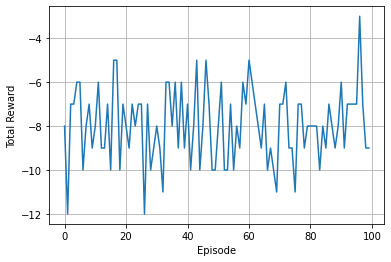

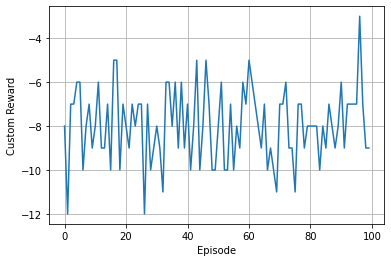

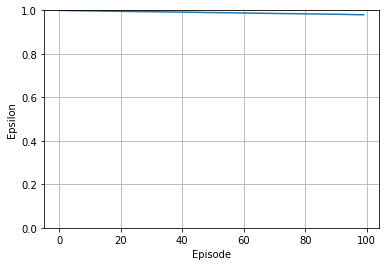

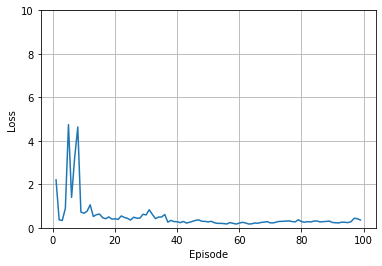

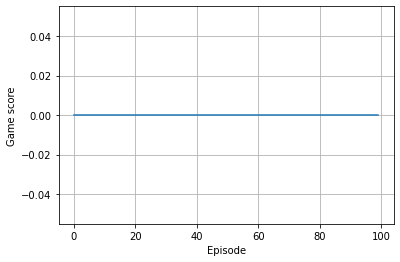

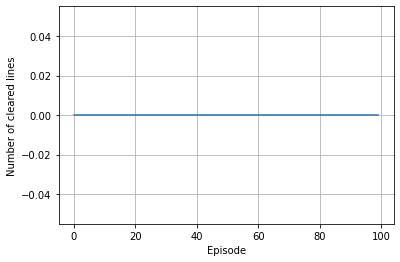

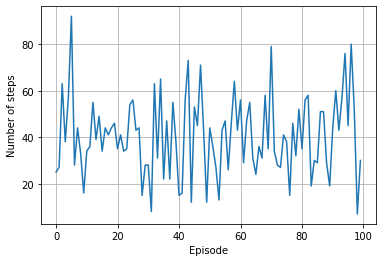

Model weights saved succesfully
Replay buffer saved succesfully
episode 100 ended after: 22 steps and 1 sec., total reward is: -6 
Epsilon=0.9797919252220945. Avg q-value prediction NRMSE=0.31614042679532584
episode 101 ended after: 69 steps and 5 sec., total reward is: -8 
Epsilon=0.9794539544662703. Avg q-value prediction NRMSE=0.3543398299713282
episode 102 ended after: 42 steps and 3 sec., total reward is: -4 
Epsilon=0.9792482902171722. Avg q-value prediction NRMSE=0.30087442057017033
episode 103 ended after: 57 steps and 4 sec., total reward is: -6 
Epsilon=0.9789692435228837. Avg q-value prediction NRMSE=0.322602540145926
episode 104 ended after: 17 steps and 1 sec., total reward is: -7 
Epsilon=0.9788860344655961. Avg q-value prediction NRMSE=0.3431059033987704
episode 105 ended after: 34 steps and 2 sec., total reward is: -9 
Epsilon=0.9787196375678804. Avg q-value prediction NRMSE=0.29528288531523683
episode 106 ended after: 17 steps and 1 sec., total reward is: -8 
Epsilon=0

In [0]:
import copy

# initialising agent and game
tetris_env = TetrisEngine()
agent = Agent(epsilon, epsilon_min, epsilon_decay)
memory_filter = MemoryFilter(agent)

NUMBER_OF_EPISODES = 20000
champion_score = -10e6

total_rewards = []
custom_rewards = []
epsilons = []
losses = []
scores = []
lines = []
steps = []

# iterate over episodes
print("Starting %d episodes: " % NUMBER_OF_EPISODES)
for ep in range(NUMBER_OF_EPISODES):

  agent.new_episode()
  current_state = tetris_env.reset()
  cond = (ep+1)%100==0
  cur_step = 0
  done = False
  last_engine_reward = 0
  tot_reward = 0
  tot_custom_reward = 0
  new_block = True

  if(cond):
    vid = cv2.VideoWriter(SRC_PATH+'/Ctetris_'+str(ep+1)+'.avi',cv2.VideoWriter_fourcc(*'XVID'), 15, (250, 500))
    #vid = cv2.VideoWriter('tetris_'+str(ep+1)+'.avi',cv2.VideoWriter_fourcc(*'XVID'), 15, (250, 500))

  # iterate over gamesteps
  start = time.time()
  while True:

    cur_step+=1

    # Render the game state
    if(cond): #only save last episode to save processing time
      frame = tetris_env.render()
      vid.write(frame)

    action = agent.get_action(current_state.reshape(1,20,10,1))
    previous_state = current_state
    current_state, last_engine_reward, done, info = tetris_env.step(action)
    new_block = info["new_block"]
      
    # if there is a new piece
    if (new_block or done):
      our_custom_reward, done = custom_reward4(previous_state, current_state)
      reward = our_custom_reward + last_engine_reward
      tot_reward+=reward
      tot_custom_reward+=our_custom_reward
      memory_filter.remember(True, [previous_state, action, reward, current_state, done])

      if (done):
        end = time.time()
        total_rewards.append(tot_reward)
        custom_rewards.append(tot_custom_reward)
        print("episode %d ended after: %d steps and %d sec., total reward is: %d " % (ep, cur_step, end-start, tot_reward))
        epsilon, loss = agent.log()
        epsilons.append(epsilon)
        losses.append(loss)
        scores.append(info['score'])
        lines.append(info['number_of_lines'])
        steps.append(cur_step)

        if (tot_reward > champion_score):
          champion_score = tot_reward

        if(cond):
          vid.release()
          print(previous_state)
          make_plots(total_rewards, custom_rewards, epsilons, losses, scores, lines, steps)
          agent.save_agent_state(ep)
        
        break

    else:
      memory_filter.remember(True, [previous_state, action, 0, current_state, done])   
       
print("The best score achieved equals %d" % champion_score)
make_plots(total_rewards, custom_rewards, epsilons, losses, scores, lines, steps)
agent.save_agent_state(ep)